In [11]:
import itertools
import re
import warnings
import numpy as np
import pandas as pd
import collections
import os
import multiprocess as mp
import pickle

from tqdm import tqdm
from joblib import Memory
from scipy.spatial import QhullError
from copy import deepcopy
from tqdm import tqdm

from ase.io import read

import pymatgen
from pymatgen.core.composition import Composition
from pymatgen.core.structure import Structure
from pymatgen.core.ion import Ion
from pymatgen.analysis.pourbaix_diagram import PourbaixDiagram, PourbaixPlotter, PourbaixEntry, IonEntry, ELEMENTS_HO
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.entries.compatibility import MaterialsProjectAqueousCompatibility, MaterialsProjectCompatibility
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.entries.computed_entries import ComputedEntry, ComputedStructureEntry
from pymatgen.ext.matproj import MPRester

%matplotlib inline
mpr = MPRester('TMnhbjaeu7Fpryl8811')
pymatgen.core.__version__

/home/ahrehd0506/miniconda3/lib/python3.8/site-packages/pymatgen/ext/matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


'2023.7.17'

### pre-define functions

In [17]:
def traj_to_computed_entry(path):
    """
    convert trajectroy with potential energy to ComputedEntry
    
    Args:
        path (str) : trajectory path
    
    Return:
        ComputedEntry
    """
    atoms = read(path)
    
    comp = Composition(str(atoms.symbols))
    energy = atoms.get_potential_energy()
    comp_dict={}
    for i in comp:
        comp_dict[str(i)] = int(comp[i])
    all_elements = [i for i in comp_dict.keys()]
    
    lda_use = False
    
    # Calculate corrections
    # Only elements that need corrections 
    correction = 0

    # Add parameters
    parameters={}
    parameters['pseudo_potential'] = {}
    parameters['pseudo_potential']['functional'] = 'RPBE'
    parameters['pseudo_potential']['pot_type'] = 'paw'
        
    # Pseudopotential related
    pp = []
    for elem in all_elements:
        if elem != 'O':
            pp.append(str(elem))

    parameters['pseudo_potential']['labels'] = pp
    parameters['potcar_symbols'] = []
    for p in pp:
        parameters['potcar_symbols'].append('RPBE '+str(p))
        
    # U related
    if lda_use == True:
        parameters['run_type'] = 'GGA+U'
        parameters['is_hubbard'] = True
    else: 
        parameters['run_type'] = 'GGA'
        parameters['is_hubbard'] = False
    
    parameters['hubbards'] = {}
    data={}

    return ComputedEntry(composition=comp, 
                         energy=energy, 
                         correction=correction, 
                         parameters=parameters, 
                         data=data, 
                         entry_id='sback')

def get_ion_ref(mpr, chemsys):
    """
      Seoin:  This is to collect reference states. It is taken from "get_pourbaix_entries"
    """
    """
    
    A helper function to get all entries necessary to generate
    a pourbaix diagram from the rest interface.    

    Args:

        chemsys ([str]): A list of elements comprising the chemical system, e.g. ['Li', 'Fe']
    """

    pbx_entries = []
    # Get ion entries first, because certain ions have reference
    # solids that aren't necessarily in the chemsys (Na2SO4)
    url = '/pourbaix_diagram/reference_data/' + '-'.join(chemsys)
    ion_data = mpr._make_request(url)
    ion_ref_comps = [Composition(d['Reference Solid']) for d in ion_data]
    ion_ref_elts = list(itertools.chain.from_iterable(i.elements for i in ion_ref_comps))
    ion_ref_entries = mpr.get_entries_in_chemsys(
            list(set([str(e) for e in ion_ref_elts] + ['O', 'H'])),
            property_data=['e_above_hull'], compatible_only=False)
    
    
    # suppress the warning about supplying the required energies; they will be calculated from the
    # entries we get from MPRester
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="You did not provide the required O2 and H2O energies.")
        compat = MaterialsProjectAqueousCompatibility(solid_compat=MaterialsProjectCompatibility())
    ion_ref_entries = compat.process_entries(ion_ref_entries)
    ion_ref_pd = PhaseDiagram(ion_ref_entries)

    # position the ion energies relative to most stable reference state
    for n, i_d in enumerate(ion_data):
        ion = Ion.from_formula(i_d['Name'])
        refs = [e for e in ion_ref_entries
                if e.composition.reduced_formula == i_d['Reference Solid']]
        if not refs:
            raise ValueError("Reference solid not contained in entry list")
        stable_ref = sorted(refs, key=lambda x: x.data['e_above_hull'])[0]
        rf = stable_ref.composition.get_reduced_composition_and_factor()[1]
        solid_diff = ion_ref_pd.get_form_energy(stable_ref) - i_d['Reference solid energy'] * rf
        elt = i_d['Major_Elements'][0]
        correction_factor = ion.composition[elt] / stable_ref.composition[elt]
        energy = i_d['Energy'] + solid_diff * correction_factor
        ion_entry = IonEntry(ion, energy)
        pbx_entries.append(PourbaixEntry(ion_entry, 'ion-{}'.format(n)))
        
        
    return pbx_entries, ion_ref_entries, ion_ref_pd

def get_pourbaix_entry_solid(entry,ion_ref_pd):
    """
    This is to calculate formation energies and convert Computed Entries to Pourbaix Entries
    """
    form_e = ion_ref_pd.get_form_energy(entry)
    computed_entry = deepcopy(entry)
    new_entry = ComputedEntry(computed_entry.composition, form_e, entry_id=computed_entry.entry_id)
    pbx_entry = PourbaixEntry(new_entry)    
    
    return pbx_entry

### function to calculate Pbx energy 
### change conditions (pH, V) in this function

In [ ]:
def calc_stability_from_pourbaix(path):
    """
    Get Pbx stability from calculated trajectory
    
    Args:
        path (str): trajectory path
    
    Return:
        stability ([list]): list with [name, energy]
    """
    
    stability = []
    name = path.split('/')[-1]
    
    try:
        
        # Convert trajectory to computed entry
        computed_entry = traj_to_computed_entry(path)
        
        # Get Pourbaix entries from composition of computed entry
        composition = computed_entry.composition
        comp_dict = {str(key): value for key, value in composition.items()
                if key not in ELEMENTS_HO}
        pourbaix_entries, ion_ref_entries, ion_ref_pd = get_ion_ref(mpr, [i for i in comp_dict.keys()])
        new_pourbaix_entry=get_pourbaix_entry_solid(computed_entry, ion_ref_pd)
        pourbaix_entries = mpr.get_pourbaix_entries(list(comp_dict.keys()))
        
        # Add the computed entry to Pourbaix entries
        pourbaix_entries.append(new_pourbaix_entry)
        entry = [entry for entry in pourbaix_entries if entry.entry_id == 'sback'][0]
        pbx = PourbaixDiagram(pourbaix_entries, comp_dict = comp_dict, filter_solids = False)

        # Get max Pourbaix energy at specific pH and volatge range
        # This example is for Pbx stability at acidic OER condition (pH 0, V = 1.23 ~ )
        energy=max(pbx.get_decomposition_energy(entry, pH=0, V=1.3),
                pbx.get_decomposition_energy(entry, pH=0, V=1.4),
                pbx.get_decomposition_energy(entry, pH=0, V=1.5),
                pbx.get_decomposition_energy(entry, pH=0, V=1.6))
        
        stability.append([name, energy])
    
    # Error return 100
    except QhullError:
        stability.append([100,100])
    except RuntimeError:
        print(name)
        
    return stability

### calculate Pbx energy

In [18]:
# Cache pourbaix_entries, most time intensive part
memory = Memory('./cachedir', verbose=0)
calc_stability_from_pourbaix_cached = memory.cache(calc_stability_from_pourbaix)

path = '/home/dbrnjsgh111/research/2eORR_DSTAR/new_tidy_up/data/calculated_neutral/' # Path to directory containing calculated trajectories with potential energy
name_list = [path + i for i in os.listdir(path)]

with mp.Pool(8) as pool:
    results = list(tqdm(pool.imap(calc_stability_from_pourbaix_cached, name_list), total=len(name_list)))

  2%|██▉                                                                                                                       | 26/1076 [00:08<05:57,  2.94it/s]Process ForkPoolWorker-57:
Process ForkPoolWorker-61:
Process ForkPoolWorker-58:
Process ForkPoolWorker-63:
Process ForkPoolWorker-60:
Process ForkPoolWorker-64:
Process ForkPoolWorker-59:



KeyboardInterrupt: 

In [30]:
# Results to dataframe

energies = []
name_lst = []

for result in (results):
    try:
        if result[0][0] != 100:
            name_list.append(result[0][0])
            energies.append(result[0][1])
            
    except IndexError:
        print(name)
        continue

df = pd.DataFrame()
df['name'] = name_list
df['Stability'] = energies

# Save
df.to_csv('../csv/acid_calculated_PBX_stability.csv')

1076


### plot Pbx diagram

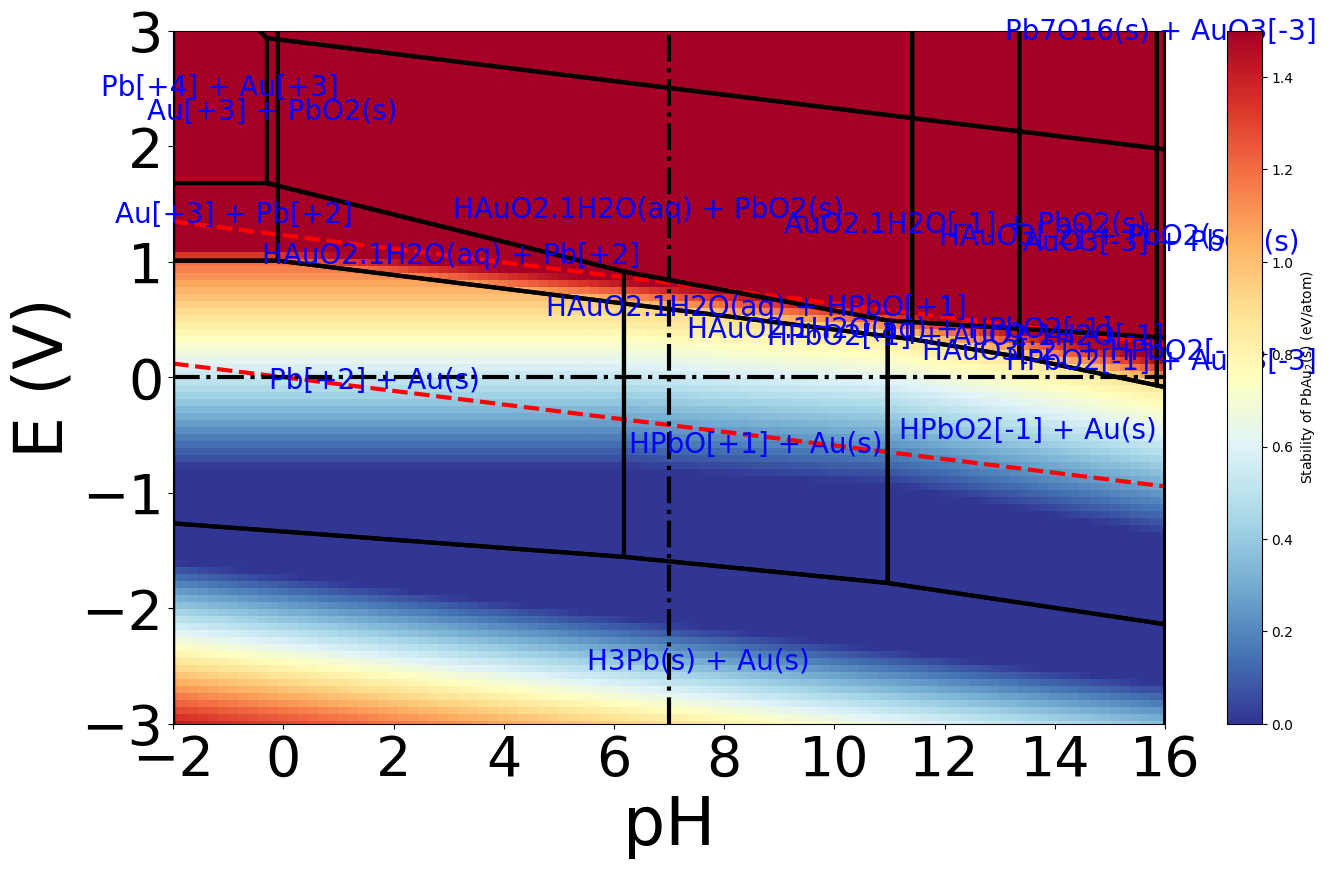

In [32]:
computed_entry=traj_to_computed_entry('./for_Acid/unreported_acid/Pb_Au_mp-985805.traj') # trajectory path
composition = computed_entry.composition
comp_dict = {str(key): value for key, value in composition.items()
            if key not in ELEMENTS_HO}
pbx_entries, ion_ref_entries, ion_ref_pd = get_ion_ref(mpr, [i for i in comp_dict.keys()])
new_pourbaix_entry=get_pourbaix_entry_solid(computed_entry, ion_ref_pd)

# Get all pourbaix entries corresponding to the chemical system of interest (don't need to include H or O)
pourbaix_entries = mpr.get_pourbaix_entries(list(comp_dict.keys()))

# Add new Pourbaix entries
pourbaix_entries.append(new_pourbaix_entry)

# Plot
pbx = PourbaixDiagram(pourbaix_entries, comp_dict = comp_dict, filter_solids = False)
entry = [entry for entry in pourbaix_entries if entry.entry_id == 'sback'][0]
plt = PourbaixPlotter(pbx).plot_entry_stability(entry,e_hull_max=1.5,label_domains=True)

In [42]:
pbx.get_decomposition_energy(entry, pH=0, V=0.7)

0.9903411833960742